# **Forcasting des prix du gazole A1 aux USA**

---



A termes, l'objectif est de **proposer des prédictions sur les prix des carburants en Ile-De-France** dans les jours à venir afin de permettre à un éventuel consommateur de prendre des décisions d'achats. Malheureusement, **la récolte des données est encore en cours** et prendra plusieurs mois.

Dans l'attente, et afin de **gagner quelques insights utiles à la prédictions des prix du carburants**, j'ai réalisé une **étude d'un cas similaire**: l'évolution des prix du carburant A1 aux Etats-Unis (All Grades All Formulations Retail Gasoline Prices).
Les données sont disponibles [ici](https://www.kaggle.com/datasets/mruanova/us-gasoline-and-diesel-retail-prices-19952021/data).

Le document suivant se propose de réaliser:

*   Une **analyse exploratoire** des données. Cette partie devrait pouvoir fournir quelques informations sur les dynamiques des prix des carburants applicables aussi aux données d'Ile-De-France.
*   Une tentative de forcasting sur 6 mois avec l'algorithme **XGBoost**.

In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.parser import parse
from datetime import datetime

In [227]:
warnings.filterwarnings('ignore')

## Préparation des données

In [228]:
# Chargement des données.
df = pd.read_csv('/content/PET_PRI_GND_DCUS_NUS_W.csv')

In [229]:
### Définition des paramètres de l'analyse

# Définition du type de carburant utilisé dans l'analyse
CARBURANT = 'A1'

# Nom de la colonne de df contenant les dates
COL_DATE = 'Date'

# Définition du lieu de l'analyse
LIEU = 'aux Etats-Unis'

# Définition de l'unité des prix
UNITE_PRIX = 'dollars par gallon'

# Définition des features et target pour XGBoost
FEATURES = [
    'jour',
    'mois',
    'annee',
    'trimestre',
    'feature_tendance',
    'stationary_target',
    'lag1', 'lag2', 'lag3'
    ]
TARGET = CARBURANT

# On définit les dates
DATE_DEBUT_VAL = '2019-01-01'
DATE_DEBUT_TEST = '2019-06-01'
DATE_FIN_TEST = '2020-01-01'  # On retire la crise du COVID

In [230]:
### Préparation des données

# Sélection des colonnes
data = df[[COL_DATE, CARBURANT]]

# Convertit la colonne 'Date' au format datetime.
data[COL_DATE] = pd.to_datetime(data[COL_DATE])

# Les dates sont utilisées comme index
data.set_index(COL_DATE, inplace=True)


print(data.head(), '\n')
print(data.tail())

               A1
Date             
1995-01-02  1.127
1995-01-09  1.134
1995-01-16  1.126
1995-01-23  1.132
1995-01-30  1.131 

               A1
Date             
2020-12-28  2.330
2021-01-04  2.336
2021-01-11  2.403
2021-01-18  2.464
2021-01-25  2.478


In [231]:
### Feature engineering

def trend_pattern(x):
    return int((x - datetime(1995, 1, 2)) / pd.Timedelta(days=1))

# Ajout d'une colonne pour aider le modèle XGBOOST à capter les saisonnalités
# éventuelles
data['mois'] = data.index.month
data['annee'] = data.index.year
data['trimestre'] = data.index.quarter
data['jour'] = data.index.dayofyear

# Ajout de colonnes de lag pour aide XGboost à tenir compte des valeurs passées
# récentes
data['lag1'] = data[CARBURANT].shift(1)
data['lag2'] = data[CARBURANT].shift(2)
data['lag3'] = data[CARBURANT].shift(3)

# Ajout d'une colonne pour aider le modèle XGBOOST à capter les tendances
# éventuelles
data['feature_tendance'] = data.index.map(trend_pattern)

# Ajout d'une colonne pour aider le modèle XGBOOST à gérer la non-stationnarité
data['stationary_target'] = data[CARBURANT].diff()
data.dropna(inplace=True)

# D'autres features assez classiques pourraient être envisagées comme
# d'utiliser une transformée de Fourier ou les résultats de seasonal_decompose

data.head()

,A1,mois,annee,trimestre,jour,lag1,lag2,lag3,feature_tendance,stationary_target
Date,,,,,,,,,,
1995-01-23,1.132,1,1995,1,23,1.126,1.134,1.127,21,0.006
1995-01-30,1.131,1,1995,1,30,1.132,1.126,1.134,28,-0.001
1995-02-06,1.124,2,1995,1,37,1.131,1.132,1.126,35,-0.007
1995-02-13,1.121,2,1995,1,44,1.124,1.131,1.132,42,-0.003
1995-02-20,1.115,2,1995,1,51,1.121,1.124,1.131,49,-0.006


In [232]:
### test/validation/train split

train = data.loc[data.index < DATE_DEBUT_VAL]
val = data.loc[(data.index >= DATE_DEBUT_VAL) & (data.index < DATE_DEBUT_TEST)]
test = data.loc[(data.index >= DATE_DEBUT_TEST) & (data.index < DATE_FIN_TEST)]

## Analyse exploratoire

---



### Valeurs extrêmes

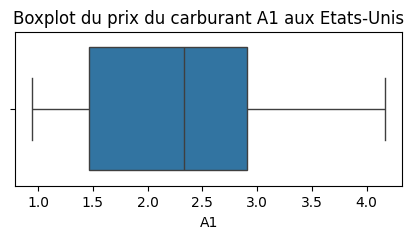

In [233]:
# Diagramme en boite de la série temporelle
sns.boxplot(data=data, x=CARBURANT)
plt.gcf().set_size_inches(5, 2)
plt.title(f'Boxplot du prix du carburant {CARBURANT} {LIEU}')
plt.show()

Il n'y a pas de valeurs extrêmes.

### Représentation des données

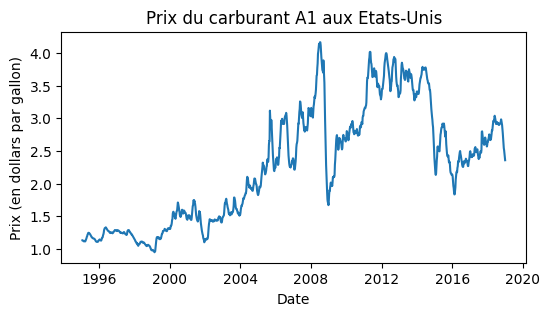

In [234]:
### Représentation des données
plt.plot(train[CARBURANT])
plt.gcf().set_size_inches(6, 3)
plt.xlabel(COL_DATE)
plt.ylabel(f'Prix (en {UNITE_PRIX})')
plt.title(f'Prix du carburant {CARBURANT} {LIEU}')
plt.show()

In [235]:
def tracer_annee(annee):
  """
  Trace le prix du carburant pour une année donnée.
  :param annee: Année pour laquelle tracer les prix.
  """
  donnee_annuelle = train.loc[(train.index >= f'{annee}-01-01') & (train.index < f'{annee+1}-01-01')]
  plt.plot(donnee_annuelle[CARBURANT])
  plt.gcf().set_size_inches(6, 2)
  plt.xlabel(COL_DATE)
  plt.ylabel(f'Prix (en {UNITE_PRIX})')
  plt.title(f'Prix du carburant {CARBURANT} {LIEU} en {annee}')
  plt.show()

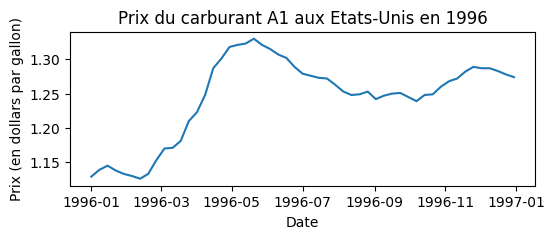

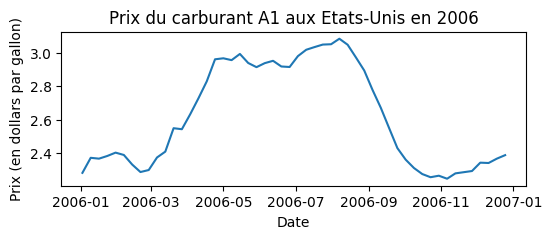

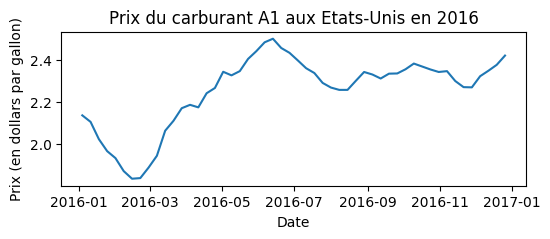

In [236]:
# On donne en illustration les représentations de quelques années du jeu
# de données.
tracer_annee(1996)
tracer_annee(2006)
tracer_annee(2016)

Il semble qu'il y ait un pique durant les étés (entre mai et septembre). Cela suggère qu'il y a une forme de saisonnalité.

In [237]:
def plot_boxplot(col, xlabel):
  """
  Crée un boxplot avec Seaborn dont l'axe des abscices est la colonne col.
  :param col: colonne de data
  :param xlabel: nom de l'axe des abscices
  """
  sns.boxplot(data=train, x=col, y=CARBURANT)
  plt.gcf().set_size_inches(13, 3)
  plt.xlabel(f'{xlabel}')
  plt.ylabel(f'Prix (en {UNITE_PRIX})')
  plt.title(f'Prix du carburant {CARBURANT} {LIEU} par {xlabel.lower()}')
  plt.show()

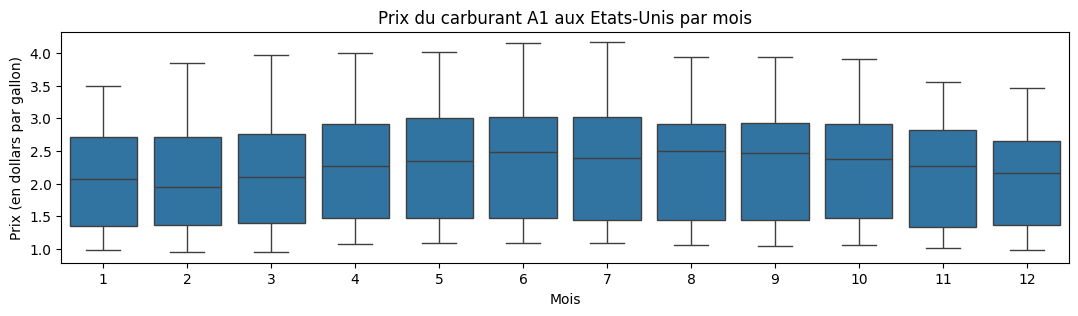

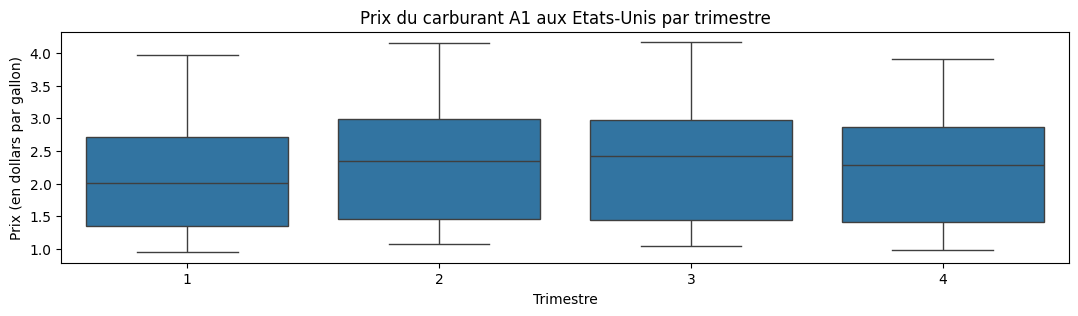

In [238]:
plot_boxplot('mois', 'Mois')
plot_boxplot('trimestre', 'Trimestre')

Ces diagrammes en boites confirment qu'il y a bien un pique durant l'été. Surement lié aux départ en vacances et donc à un accroissement de la demande. On constate aussi que le premier trimestre a les prix les plus bas. On peut certainement s'attendre à plusieurs niveaux de saisonnalités dans le jeu de donnée (annuelle et trimestrielle). Les méthodes statistiques classiques comme SARIMA sont peu adaptées.

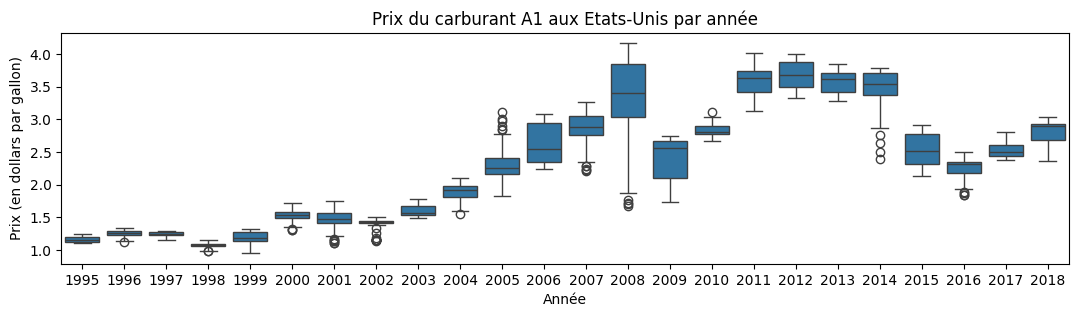

In [239]:
plot_boxplot('annee', 'Année')

Les prix du pétrole ont tendance à augmenter avec le temps à quelques exceptions près dont les plus notables sont:
* La crise financière asiatique de 1998 qui entraine une baisse de la demande mondiale qui n'avait pas été anticipée pas les pays producteurs.
* La crise des subprimes en 2008 qui se transforme en crise financière mondiale l'année suivante.
* Le crash pétrolier de 2014 (lié à un trop haut niveau d'offre).

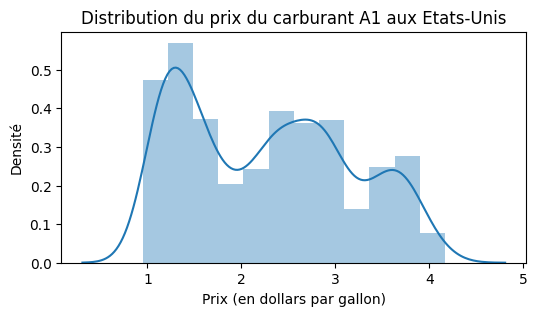

In [240]:
### Distribution des prix
plt.title(f'Distribution du prix du carburant {CARBURANT} {LIEU}')
sns.distplot(train[CARBURANT])
plt.gcf().set_size_inches(6, 3)
plt.ylabel('Densité')
plt.xlabel(f'Prix (en {UNITE_PRIX})')
plt.show()

### Décomposition de la série temporelle

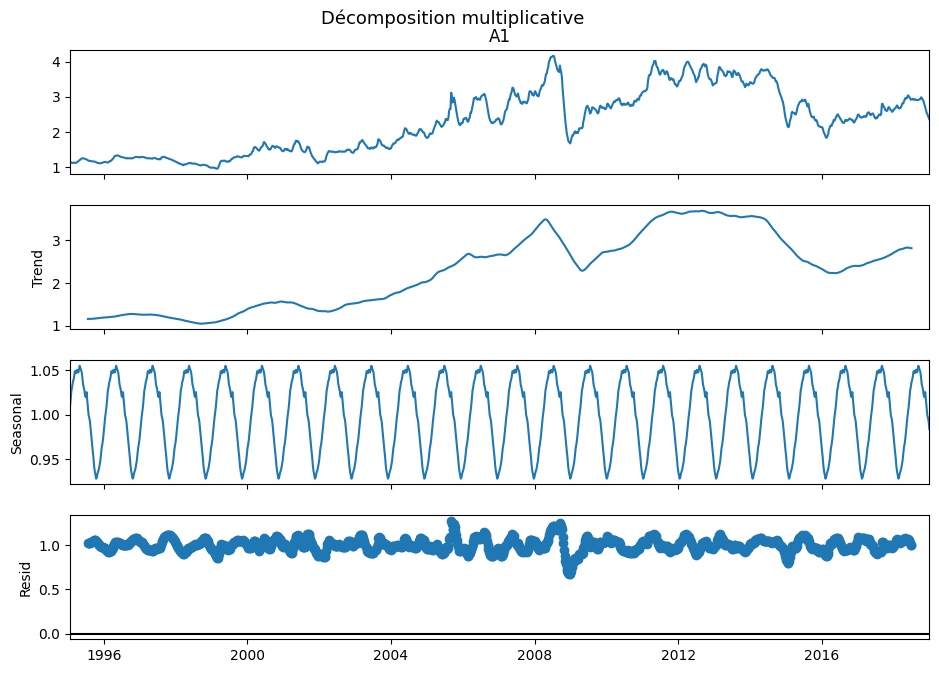

In [241]:
# Décomposition multiplicative
multiplicative_decomposition = seasonal_decompose(train[CARBURANT], model='multiplicative', period=53)

# Graphe
multiplicative_decomposition.plot()
plt.suptitle('Décomposition multiplicative', fontsize=13)
plt.gcf().set_size_inches(10, 7)

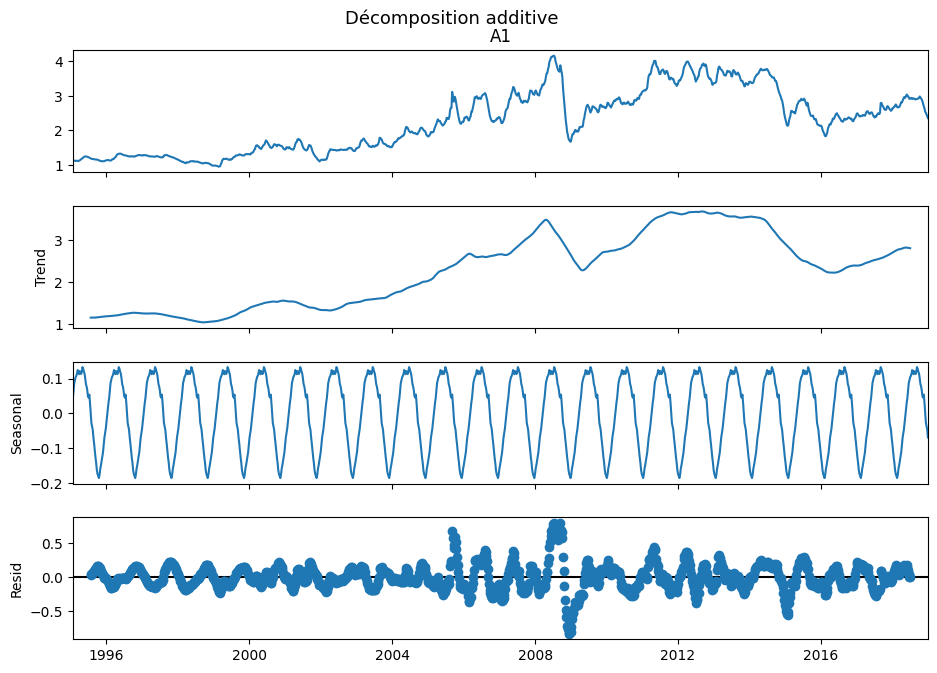

In [242]:
# Décomposition additive
additive_decomposition = seasonal_decompose(train[CARBURANT], model='additive', period=53)

# Plot
additive_decomposition.plot().suptitle('Décomposition additive', fontsize=13)
plt.gcf().set_size_inches(10, 7)

Les décompositions ETS montrent clairement que la série possède une saisonnalité mais cette dernière semble assez faible. La tendance est l'aspect le plus important pour déterminer le prix du carbirant A1.
Il est à noter, même si on ne s'en servira pas dans cette étude de cas, que la série semble plutôt multiplicative.

### Stationnarité

Un simple coup d'oeil au graphe de la série suffit à voir qu'elle n'est pas stationnaire (ni la moyenne, ni la variance ne sont constante). Cependant, on peut le vérifier plus formellement avec un test ADF de Stationnarité.

In [243]:
### Test ADF de stationnarité
def adf_test(timeseries):
  """

  """
  print("Results of Dickey-Fuller Test:")
  dftest = adfuller(timeseries, autolag="AIC")
  dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
        ],
    )
  for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
  print(dfoutput)


adf_test(train[CARBURANT])  # p-value > 0.05 => la série est non-stationnaire

Results of Dickey-Fuller Test:
Test Statistic                   -2.398421
p-value                           0.142183
#Lags Used                        3.000000
Number of Observations Used    1246.000000
Critical Value (1%)              -3.435609
Critical Value (5%)              -2.863862
Critical Value (10%)             -2.568006
dtype: float64


Elle devient en revanche stationnaire après une seule différenciation.

In [244]:
train_diff = train.copy()
train_diff = diff(train[CARBURANT], k_diff=1)
adf_test(train_diff)  # p-value < 0.05 => la série est stationnaire

Results of Dickey-Fuller Test:
Test Statistic                -1.031366e+01
p-value                        3.137752e-18
#Lags Used                     8.000000e+00
Number of Observations Used    1.240000e+03
Critical Value (1%)           -3.435635e+00
Critical Value (5%)           -2.863874e+00
Critical Value (10%)          -2.568012e+00
dtype: float64


### Autocorrélation et Autocorrélation partielle

L'analyse conjointe des graphes d'autocorrélation (ACF) et d'autocorrélation partielle (PACF) révèle une forte structure temporelle dans la série des prix du carburant. Le ACF montre une persistance à long terme et une possible saisonnalité ayant un cycle d'environ 1 an, tandis que le PACF indique une dépendance significative principalement sur les deux premiers décalages.

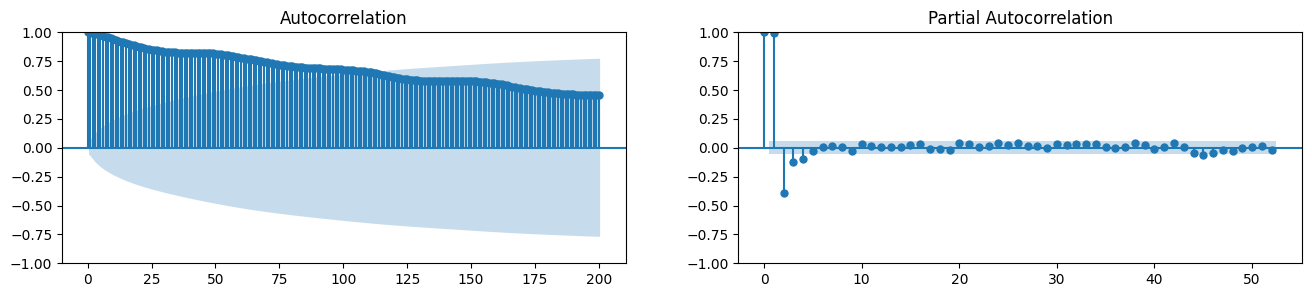

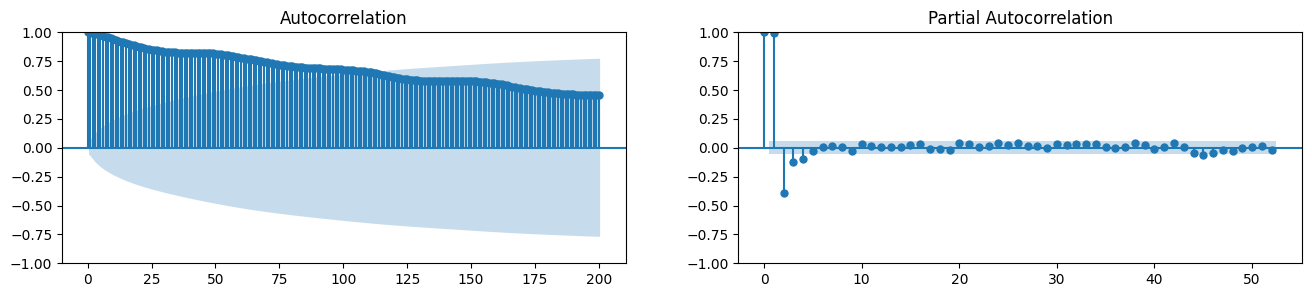

In [245]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train[CARBURANT].tolist(), lags=200, ax=axes[0])
plot_pacf(train[CARBURANT].tolist(), lags=52, ax=axes[1])

### Bilan de l'analyse exploratoire

L'analyse exploratoire montre que notre modèle XGBoost aura besoin, pour fonctionner correctement, de features permettant, à minima, de capter:
* La faible saisonnalité des données
* L'influence forte des dernières valeurs de la série
* L'aspect non-stationnaire de la série.

## Modèle linéaire

On commence par construire un modèle linéaire simple qui servira de point de comparaison.

In [246]:
from sklearn.linear_model import LinearRegression

X_train = train[['jour', 'mois', 'annee']]
y_train = train[TARGET]
X_val = val[['jour', 'mois', 'annee']]
y_val = val[TARGET]

In [247]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

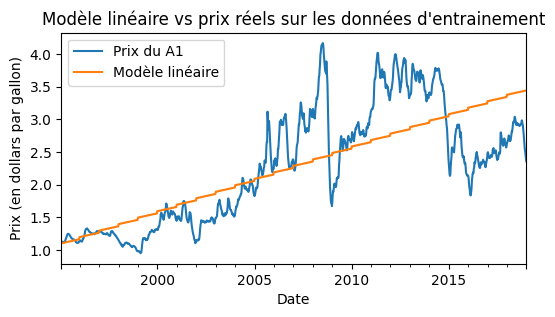

In [248]:
y_pred = pd.Series(model.predict(X_train), index=X_train.index, name='prédictions' )
ax = y_train.plot(label = f'Prix du {CARBURANT}')
y_pred.plot(label = 'Modèle linéaire', ax=ax)
plt.legend()
plt.title("Modèle linéaire vs prix réels sur les données d'entrainement")
plt.ylabel(f'Prix (en {UNITE_PRIX})')
plt.gcf().set_size_inches(6, 3)

In [249]:
print("rmse sur les données d'entrainement :", root_mean_squared_error(y_train, y_pred))

rmse sur les données d'entrainement : 0.5663770191042375


In [250]:
y_pred = pd.Series(model.predict(X_val), index=X_val.index, name='prédictions' )

In [251]:
print("rmse sur les données de validation", root_mean_squared_error(y_val, y_pred))

rmse sur les données de validation 0.8810415387776797


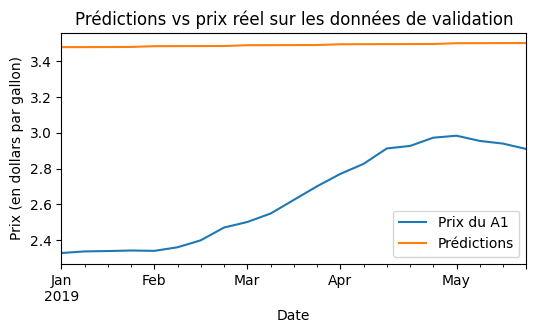

In [252]:
ax = y_val.plot(label = f'Prix du {CARBURANT}')
y_pred.plot(label = 'Prédictions', ax=ax)
plt.legend()
plt.title('Prédictions vs prix réel sur les données de validation')
plt.ylabel(f'Prix (en {UNITE_PRIX})')
plt.gcf().set_size_inches(6, 3)

## Modèle XGBoost

In [253]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_val = val[FEATURES]
y_val = val[TARGET]

### Recherche des hyperparamètres du modèles

In [254]:
# On définit les paramètres initiaux du modèle
param = {
    'learning_rate': 0.02,
    'n_estimators': 1001,
    'max_depth': 5,
    'min_child_weight': 1,
    'min_child_depth': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'nthread': 4,
    'scale_pos_weight': 1,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'seed': 42
}

In [255]:
def get_optim_param_XGBoost(X_train, y_train, param_test, param):
  gsearch = GridSearchCV(
      param_grid = param_test,
      scoring = 'neg_mean_squared_error',
      n_jobs = 4,
      cv = 10,
      estimator = xgb.XGBRegressor(
          learning_rate = param['learning_rate'],
          n_estimators = param['n_estimators'],
          max_depth = param['max_depth'],
          min_child_weight = param['min_child_weight'],
          min_child_depth = param['min_child_depth'],
          gamma = param['gamma'],
          subsample = param['subsample'],
          colsample_bytree = param['colsample_bytree'],
          objective = param['objective'],
          nthread = param['nthread'],
          scale_pos_weight  = param['scale_pos_weight'],
          reg_alpha = param['reg_alpha'],
          reg_lambda = param['reg_lambda'],
          seed  = param['seed']
          )
      )
  gsearch.fit(X_train, y_train)
  return gsearch.best_params_, gsearch.best_score_

#### Optimisation des hyperparamètres spécifiques des arbres

In [256]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'min_child_depth': range(1,6,2)
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test1, param)

In [257]:
best_score

-0.001639614342880533

In [258]:
max_depth = best_param['max_depth']
min_child_weight = best_param['min_child_weight']
min_child_depth = best_param['min_child_depth']

In [259]:
if max_depth == 1:
  max_depth = 2
if min_child_weight == 1:
  min_child_weight = 2
if min_child_depth == 1:
  min_child_depth = 2

param_test1 = {
 'max_depth': [max_depth-1,max_depth,max_depth+1],
 'min_child_weight': [min_child_weight-1,min_child_weight,min_child_weight+1],
 'min_child_depth': [min_child_depth-1,min_child_depth,min_child_depth+1]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test1, param)

In [260]:
best_score

-0.001639614342880533

In [261]:
param['max_depth'] = best_param['max_depth']
param['min_child_weight'] = best_param['min_child_weight']
param['min_child_depth'] = best_param['min_child_depth']

#### Optimisation du paramètre Gamma

In [262]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,8)]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test2, param)

In [263]:
best_score

-0.001639614342880533

In [264]:
param['gamma'] = best_param['gamma']

#### Omptimisation des paramètres subsample et colsample_bytree

In [265]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test3, param)

In [266]:
best_score

-0.0014099988184688938

In [267]:
param['subsample'] = best_param['subsample']
param['colsample_bytree'] = best_param['colsample_bytree']

#### Optimisation des paramètres de régularisation

In [268]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test4, param)

In [269]:
best_score

-0.0014150631187066832

In [270]:
param['reg_alpha'] = best_param['reg_alpha']
reg_alpha = best_param['reg_alpha']

In [271]:
param_test4 = {
 'reg_alpha': [i*reg_alpha/10 for i in range(0,11)] + [i*reg_alpha for i in range(2,11)]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test4, param)

In [272]:
best_score

-0.0014087293936282694

In [273]:
param['reg_alpha'] = best_param['reg_alpha']

In [274]:
param_test5 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 10, 100]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test5, param)

In [275]:
best_score

-0.001410224557472096

In [276]:
param['reg_lambda'] = best_param['reg_lambda']
reg_lambda = best_param['reg_lambda']

In [277]:
param_test5 = {
 'reg_lambda': [i*reg_lambda/10 for i in range(0,11)] + [i*reg_lambda for i in range(2,11)]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test5, param)

In [278]:
best_score

-0.0014083949492892085

In [279]:
param['reg_lambda'] = best_param['reg_lambda']

#### Optimisation du learning rate

In [280]:
param_test6 = {
    'learning_rate': [i/100 for i in range(0,11)]
}

best_param, best_score = get_optim_param_XGBoost(X_train, y_train, param_test6, param)

In [281]:
best_score

-0.0014083949492892085

In [282]:
param['learning_rate'] = best_param['learning_rate']
learning_rate = best_param['learning_rate']

In [283]:
param

{'learning_rate': 0.02,
 'n_estimators': 1001,
 'max_depth': 5,
 'min_child_weight': 3,
 'min_child_depth': 1,
 'gamma': 0.0,
 'subsample': 0.8,
 'colsample_bytree': 0.9,
 'objective': 'reg:linear',
 'nthread': 4,
 'scale_pos_weight': 1,
 'reg_alpha': 1.0000000000000002e-06,
 'reg_lambda': 8.000000000000001e-06,
 'seed': 42}

#### Entrainement du modèle

In [293]:
reg = xgb.XGBRegressor(
    n_estimators = 3000,
    max_depth = param['max_depth'],
    min_child_weight = param['min_child_weight'],
    min_child_depth = param['min_child_depth'],
    gamma = param['gamma'],
    subsample = param['subsample'],
    colsample_bytree = param['colsample_bytree'],
    objective = param['objective'],
    nthread = param['nthread'],
    scale_pos_weight  = param['scale_pos_weight'],
    reg_alpha = param['reg_alpha'],
    reg_lambda = param['reg_lambda'],
    seed  = param['seed'],
    learning_rate = param['learning_rate']
    )

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_depth=1, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=None, nthread=4, ...)

In [294]:
# Vérifions le poids des features
pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

,importance
jour,0.000178
mois,0.000053
annee,0.000179
trimestre,0.000025
feature_tendance,0.001186
stationary_target,0.002688
lag1,0.724725
lag2,0.270809
lag3,0.000157


#### Visualisation des résultats

In [295]:
def predict(X_features):
  val = X_features.copy()
  val['predictions'] = 0
  val['lag1'][1:] = 0
  val['lag2'][2:] = 0
  val['lag3'][3:] = 0

  res = reg.predict(val[FEATURES].loc[[val.index[0]]])
  val.loc[val.index[1], 'lag1'] = res
  val.loc[val.index[2], 'lag2'] = res
  val.loc[val.index[3], 'lag3'] = res
  val.loc[val.index[0], 'predictions'] = res[0]

  res = reg.predict(val[FEATURES].loc[[val.index[1]]])
  val.loc[val.index[2], 'lag1'] = res
  val.loc[val.index[3], 'lag2'] = res
  val.loc[val.index[4], 'lag3'] = res
  val.loc[val.index[1], 'predictions'] = res[0]

  for i in range(3,val.shape[0]-2):
    res = reg.predict(val[FEATURES].loc[[val.index[i-1]]])
    val.loc[[val.index[i]],'lag1'] = res
    val.loc[val.index[i+1], 'lag2'] = res
    val.loc[val.index[i+2], 'lag3'] = res
    val.loc[[val.index[i-1]],'predictions'] = res[0]

  res = reg.predict(val[FEATURES].loc[[val.index[-3]]])
  val.loc[[val.index[-3]],'predictions'] = res[0]
  val.loc[val.index[-2], 'lag1'] = res
  val.loc[val.index[-1], 'lag2'] = res

  res = reg.predict(val[FEATURES].loc[[val.index[-2]]])
  val.loc[[val.index[-2]],'predictions'] = res[0]
  val.loc[val.index[-1], 'lag1'] = res

  res = reg.predict(val[FEATURES].loc[[val.index[-1]]])
  val.loc[[val.index[-1]],'predictions'] = res[0]

  return val['predictions']

In [296]:
val_pred = predict(X_val)

In [297]:
root_mean_squared_error(val_pred, data.iloc[(data.index >= DATE_DEBUT_VAL) & (data.index < DATE_DEBUT_TEST)][CARBURANT])

0.035324032142967185

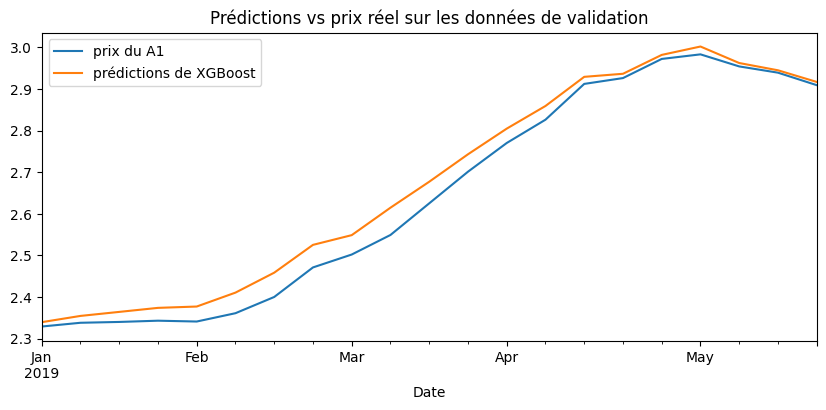

In [298]:
ax = data.iloc[(data.index >= DATE_DEBUT_VAL) & (data.index < DATE_DEBUT_TEST)][CARBURANT].plot(label = f'prix du {CARBURANT}')
val_pred.plot(label = 'prédictions de XGBoost', ax = ax)
plt.legend()
plt.title('Prédictions vs prix réel sur les données de validation')
plt.gcf().set_size_inches(10, 4)

In [299]:
test_pred = predict(test[FEATURES])

In [300]:
root_mean_squared_error(test_pred, data.iloc[(data.index >= DATE_DEBUT_TEST) & (data.index < DATE_FIN_TEST)][CARBURANT])

0.047518729894375535

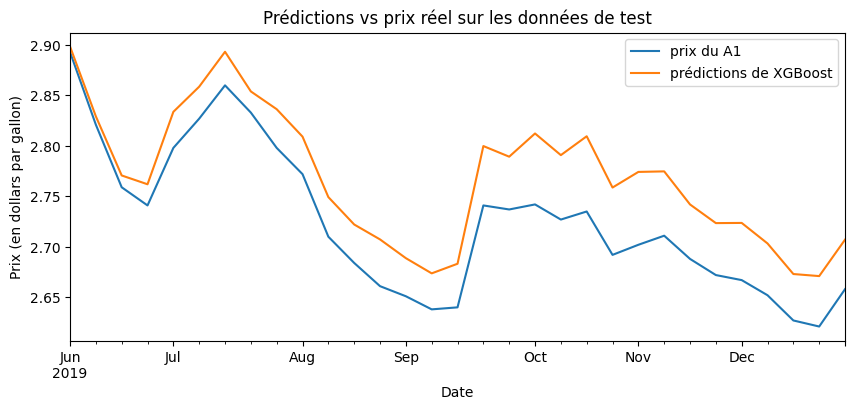

In [302]:
ax = data.iloc[(data.index >= DATE_DEBUT_TEST) & (data.index < DATE_FIN_TEST)][CARBURANT].plot(label = f'prix du {CARBURANT}')
test_pred.plot(label = 'prédictions de XGBoost', ax = ax)
plt.legend()
plt.title('Prédictions vs prix réel sur les données de test')
plt.ylabel(f'Prix (en {UNITE_PRIX})')
plt.gcf().set_size_inches(10, 4)